# Import Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica DataSet

In [3]:
import load_dataset

groundtruth_dir = r"D:\Andrea\Downloads\gzp"
dataset_dir = r"D:\Andrea\Downloads\Paris120x120"

class_names = load_dataset.get_classnames()
num_classes = len(class_names)

dataset = load_dataset.get_dataset(groundtruth_dir, dataset_dir, class_names)

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


Funzioni per la stampa di statistiche sul DB

In [4]:
import print_functions as prt

prt.print_dataset_stats(dataset)

Numero immagini del dataset:  3387
Numero di immagini nei vari landmark:  [232. 129. 683. 266. 249. 345.  90. 205. 319. 147. 279. 443.]
Immagini good-ok-bad-junk:  [0, 1779, 0, 1608]
Per ogni landmark, quanti sono quelli good, ok, bad e junk: [[0, 124, 0, 108], [0, 61, 0, 68], [0, 268, 0, 415], [0, 182, 0, 84], [0, 131, 0, 118], [0, 237, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 144, 0, 135], [0, 268, 0, 175]]


# Split dei dati in training, validation, test set

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import random

In [6]:
# Da Dataset -> A X_train, X_val, X_test

# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

x_train_len = prt.dataset_len(x_train)
x_val_len = prt.dataset_len(x_val)

print(prt.dataset_len(x_train))
print(prt.dataset_len(x_val))
print(prt.dataset_len(x_test))

2709
334
344


# Data Augmentation

Definizione degli ImageDataGenerator. Gli oggetti ImageDataGenerator definiscono le trasformazioni che si faranno.
Chiamando flow(numpy_array_immagini) su ImageDataGenerator, flow restituirà un generatore di immagini transformate.

In [7]:
#oggetto ImageDataGenerator, definisce le trasformazioni
gen_settings = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=60,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False,                     
    rescale=None,
    fill_mode='nearest'
)

#ImageDataGenerator senza trasformazioni per validation set
test_val_settings = keras.preprocessing.image.ImageDataGenerator()

Ora definiamo una classe custom che prende gli ImageDataGenerator del nostro dataset, e gli usa per creare un generatore di triplette.

In [8]:
class CustomDataGenerator(object):
    
    # parametro nel costruttore: dataset_generators. Ha la solita struttura [ [[good],[ok],[bad],[junk]],  [...], ...]
    # però invece che avere le foto nei good, ok, ... ho un generatore per quella categoria che genera le trasformazioni
    
    def __init__(self, dataset_generators) -> None:
        self.dataset_generators = dataset_generators

    def next_train(self):
        current_class = -1
        while 1:
            current_class = current_class+1
            current_class = current_class % num_classes
            different_class = random.randint(0, num_classes-1)

            while(different_class == current_class):
                different_class = random.randint(0, num_classes-1)  
            
            anchor = next(self.dataset_generators[current_class][1])[0]
            positive = next(self.dataset_generators[current_class][1])[0]
            negative = next(self.dataset_generators[different_class][random.choice([1,3])])[0]
            
            anchor = tf.convert_to_tensor([anchor])#se metto anchor invece di [anchor], quando faccio fit non funziona. Da capire
            positive = tf.convert_to_tensor([positive])
            negative = tf.convert_to_tensor([negative])
            
            triplet = (anchor, positive, negative)
            yield(triplet)

x_train, x_val, x_test sono strutture dati di immagini così disposte: [ [[good],[ok],[bad],[junk]],  [...], ...]
Sostituiamo le immagini coi generatori creati a partire da quelle immagini.

In [9]:
import numpy as np

#x_train, x_val, x_test prima contenevano array di immagini. Ora contengono generatori separati per classe e qualità
def transform_dataset(ds, gen_settings):
    for i in range(len(ds)):
        for j in [1,3]: #abbiamo solo immagini ok e junk (1 e 3) nel database
            generatore = gen_settings.flow(x=np.asarray(ds[i][j]), batch_size=1) #batch size 1 per ritornare una sola img
            ds[i][j] = generatore
    return ds

x_train = transform_dataset(x_train, gen_settings)
x_val = transform_dataset(x_val, test_val_settings)
#x_test = transform_dataset(x_test, test_val_settings)

In [10]:
#Training generator
custom_gen_train = CustomDataGenerator(x_train)
generatore_triplete_train = custom_gen_train.next_train()

#Validation generator
custom_gen_val = CustomDataGenerator(x_val)
generatore_triplete_val = custom_gen_val.next_train() 

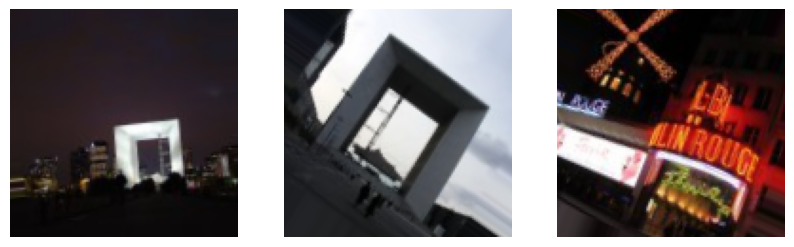

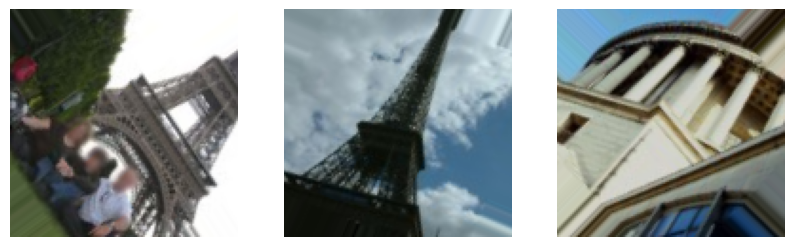

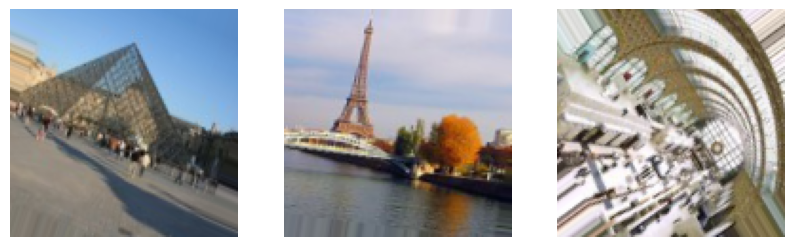

In [11]:
prt.stampa_tripletta(next(generatore_triplete_train))
prt.stampa_tripletta(next(generatore_triplete_train))
prt.stampa_tripletta(next(generatore_triplete_train))

# Definizione Modello Triple

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input

In [13]:
def get_encoder (input_shape):
    
    base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False)
    
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
        
    encode_model = tf.keras.models.Sequential([
        base_cnn,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32)
    ], name="Embedding")
    
    
    return encode_model

In [14]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [15]:
def get_siamese_network (input_shape = (120,120,3)):
    embedding_model = get_encoder(input_shape)
    input_anchor = tf.keras.layers.Input(shape= input_shape)
    input_positive = tf.keras.layers.Input(shape= input_shape)
    input_negative = tf.keras.layers.Input(shape= input_shape)
    
    embedding_anchor = embedding_model(resnet.preprocess_input(input_anchor))
    embedding_positive = embedding_model(resnet.preprocess_input(input_positive))
    embedding_negative = embedding_model(resnet.preprocess_input(input_negative))

    #embedding_anchor = embedding_model(input_anchor)
    #embedding_positive = embedding_model(input_positive)
    #embedding_negative = embedding_model(input_negative)

    distances = DistanceLayer()(
    embedding_anchor ,
    embedding_positive,
    embedding_negative ,
    )

    siamese_network =  tf.keras.models.Model(
    inputs=[input_anchor, input_positive, input_negative], outputs=distances
    )
    return siamese_network
    
siamese_network = get_siamese_network()  

In [16]:
class SiameseModel(tf.keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker =tf.keras.metrics.BinaryAccuracy(name ="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
        with tf.GradientTape() as tape:
            loss,acc = self._compute_loss(data)
        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, data):
        
        loss,acc = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss, (ap_distance<an_distance)
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker,self.acc_tracker]

In [17]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), weighted_metrics=[])

In [19]:
#history = siamese_model.fit(triplet_train, epochs=1, validation_data=triplet_val)

# siccome uso un generator, la dimensione del dataset diventa potenzialmente infinita
# devo definire a quanti batch corrisponde un'epoca -> steps per epoch, validation steps

history = siamese_model.fit(
    generatore_triplete_train,
    steps_per_epoch=x_train_len,
    epochs=10,
    verbose=1,
    validation_data=generatore_triplete_val,
    validation_steps=x_val_len
)


Epoch 1/10
2709/2709 [==============================] - 361s 128ms/step - loss: 0.5028 - acc: 0.5537 - val_loss: 0.4067 - val_acc: 0.6677
Epoch 2/10
2709/2709 [==============================] - 320s 118ms/step - loss: 0.4715 - acc: 0.5871 - val_loss: 0.4094 - val_acc: 0.6437
Epoch 3/10
2709/2709 [==============================] - 315s 116ms/step - loss: 0.4525 - acc: 0.6081 - val_loss: 0.3783 - val_acc: 0.6707
Epoch 4/10
2709/2709 [==============================] - 320s 118ms/step - loss: 0.4196 - acc: 0.6489 - val_loss: 0.3144 - val_acc: 0.7186
Epoch 5/10
2709/2709 [==============================] - 313s 115ms/step - loss: 0.4284 - acc: 0.6328 - val_loss: 0.3623 - val_acc: 0.6826
Epoch 6/10
2709/2709 [==============================] - 394s 145ms/step - loss: 0.4287 - acc: 0.6293 - val_loss: 0.3875 - val_acc: 0.6976
Epoch 7/10
2709/2709 [==============================] - 396s 146ms/step - loss: 0.4242 - acc: 0.6318 - val_loss: 0.3244 - val_acc: 0.7575
Epoch 8/10
2709/2709 [============

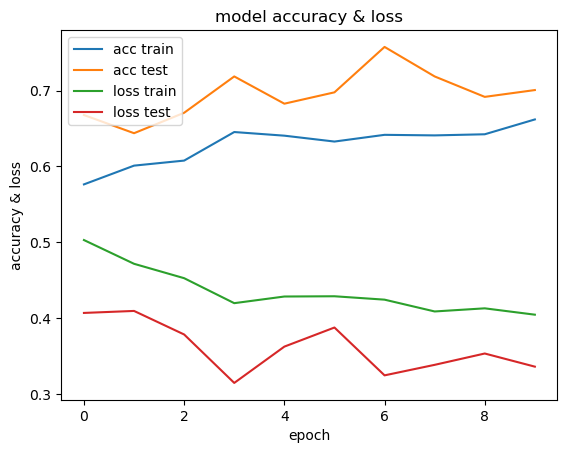

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc test', 'loss train','loss test'], loc='upper left')
plt.show()

# Usare il modello allenato

Runnare questa cella solo se non si ha il modello "encoder" salvato

In [26]:
def exctract_embedding(model):
    encoder=get_encoder((120,120,3))
    i=0
    for e_layer in model.layers[0].layers[9].layers:
        layer_weight= e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder
encoder=exctract_embedding(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

ResourceExhaustedError: failed to allocate memory [Op:Mul]

Runnare questa cella solo se si sono già calcolati i pesi per il modello "encoder"

In [22]:
encoder=get_encoder((120,120,3))
encoder.load_weights("encoder")

Data un immagine in ingresso, trovare quale immagine appartenente al training set sia la più vicina, e classificare l'immagine in base al graound truth dell'immagine più simile

In [33]:
#Calcolo per ogni immagine del training set l'output attraverso l'encode
def makeX_Y_array (array):
    
    arrT=[] # array di immagini good e ok prese dal parametro 'array'. T sta per Tensor
    y_arrT= [] # array contenente la classe in base all'immagine
    y_levels=[] # y_levels[i] mi indica, per la classe i, l'indice in arrT relativo all'ultimo elemento
                # appartenete a quella classe
    previous=0

    for index in range(len(class_names)):
        #riempiamo arrT
        arrT.extend(array[index][0]) # [i] indica la classe [j] indica la qualita [k] la foto singola
        arrT.extend(array[index][1])

        #riempiamo y_arrT
        totLen=len(array[index][0])+len(array[index][1])
        k=np.zeros(totLen)
        k.fill(index)
        y_arrT.extend(k)
    
        #riempiamo y_levels
        y_levels.append(previous+totLen)
        previous=y_levels[index]
    
    ###################dimezzo i vettori per la poca memoria, da togliere nella versione finale
    #arrT = arrT[0:round(len(arrT)/2)]
    #y_arrT = y_arrT[0:round(len(y_arrT)/2)]

    #conversione in array tensor
    #arrT= tf.data.Dataset.from_tensor_slices(arrT)
    #y_arrT = tf.data.Dataset.from_tensor_slices (y_arrT)
    
    #divisione degli array in batch
    #arrT=arrT.batch(32,drop_remainder=False)
    #y_arrT=y_arrT.batch(32,drop_remainder=False)
    
    return arrT, y_arrT,y_levels

In [24]:
dt,y_train,y_levels = makeX_Y_array(x_train)

In [25]:
points=encoder.predict(dt)

In [26]:
def classify_images(tensor):
    distance = tf.reduce_sum(tf.square(points - tensor), -1)
    return distance

def retrieve_label(tensor): 
    #visto che non è possibile fare y_train[tensore]
    #per ritrovare la classe sottraggo il valore dell'immagine più vicina
    #a y_levels che contiene l'indice dell'ultimo elemento della classe rispetto al dataset in ingresso
    # successivamente trovo tutti i valori maggiori di 0 e ne faccio la somma.
    a=tf.map_fn(lambda x :y_levels-x,tensor) 
    a=tf.cast(tf.math.greater_equal(a,0),tf.int32)  
    a=tf.map_fn(tf.reduce_sum,a)
    #sottraggo la somma con class names e ritrovo l'indice della classe
    a= len(class_names)-a
    return a

class DistanceClassificationLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.points=points

    def call(self, tensor):
        #per ogni immagine vado a calcolare la distanza rispetto a tutti le foto del training set
        predicts = tf.map_fn(classify_images,tensor)
        predicts=tf.argmin(predicts,-1) #prendo l'indice dell'immagine rispetto al training set con la distanza minore
        return retrieve_label(predicts) # ritrovo dall'indice la classe
       
    
       
evaluation_model=tf.keras.models.Sequential([encoder,DistanceClassificationLayer()]) 

Vado a creare un dataset dove (x_test, classi associata)

In [34]:
evaluate_dt,res,re_levels= makeX_Y_array(x_test)
evaluate_dt= tf.data.Dataset.zip((evaluate_dt,res))

TypeError: The argument to `Dataset.zip()` must be a (nested) structure of `Dataset` objects. Python `list` is not supported, please use a `tuple` instead.

In [28]:
#evaluation_model.compile(
#    optimizer='sgd',
#    loss='mse',
    #metrics=[tf.keras.metrics.TopKCategoricalAccuracy()],
#)
    
evaluation_model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy()]) # qui ci andrebbe il topK ma non funziona
evaluation_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Sequential)       (None, 32)                40508064  
_________________________________________________________________
distance_classification_laye (None,)                   0         
Total params: 40,508,064
Trainable params: 25,850,144
Non-trainable params: 14,657,920
_________________________________________________________________


In [29]:
evaluation_model.evaluate(evaluate_dt)

6/6 [==============================] - 3s 350ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.1667


[0.0, 0.1666666716337204]

In [35]:
print(res)
print(len(evaluate_dt), len(evaluate_dt[0]), len(evaluate_dt[0][0]), len(evaluate_dt[0][0][0]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
180 120 120 3


In [31]:
prova = evaluation_model.predict(evaluate_dt)

In [32]:
print(prova)

[ 3  3 11  2  5  0  7 11  3  1  2  0  3  2  2  1  2  3  2 10  2  9  2  0
  1  2 11  3  8  3  3  2 11  3  2  3  2  5  7  7  2 11  7  2  1  3  3  3
  3  2  3  3  3  3  8  0  5 10  1  5  3  3  1 10  7  2  4  7  4  5  3  9
  4  2  3  3 11  5  5  5  3  2  5  4  0  2  2  0  2  8  2  4  5  5  7  5
  2 10  5 11 10  6  9  9  4  6  6  2 11  7 10  9  7  7  1 10 10 11  2 11
  3 10  8  2 10  8  8  8  8  4 11 10  7  3  9  9  2 11  7  3  5 10 10 10
 10  2  0 10 10  3  3  7 10 11  5  3  2  1 11 11 11  5  6  4  5  6 11  1
 11  2  5 10  2 11  3  4  0  0 11  0]
